## The effect of agriculture on the population of breeding birds in the Netherlands


### Introduction

The biodiversity of our planet is very essential for all the living organisms on earth. Unfortunately, the biodiversity has changed fast in the last decades. This change is caused mainly by human activities like agriculture. Agriculture can be harmful for ecosystems and can cause the loss of biodiversity. Even in the Netherlands there has been a loss of biodiversity during the last decades because of agriculture. 

This research focusses on the breeding bird population in the Netherlands. Birds are very important and are part of the biodiversity. They play an important role in the food chain and in the pollution of plants.

### Research question

What is the effect of agriculture on the population of breeding birds in the Netherlands?

### The data

Two datasets were used during this research. Both came from a different source.

The agriculture data came from Centraal Bureau voor Statestiek (CBS)
https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=80781ned&_theme=302

The bird population data came from sovon
https://sovon.nl/indexen-en-aantallen




### Code 

In [302]:
# The imports

import yaml
import pandas as pd
from datetime import datetime
from bokeh.plotting import figure, show, ColumnDataSource
import numpy as np
import regex as re
import pandas as pd
import panel as pn
from deep_translator import GoogleTranslator
from bokeh.io import output_notebook
from bokeh.models import LinearAxis, Range1d
import geopandas as gpd
output_notebook()


Loading BokehJS ...

### Creating dataframes from the files

In [303]:
def opening_file(file_name):
    with open("config.yaml", "r") as config_reader:
        files = yaml.safe_load(config_reader)
        file_reader = pd.read_csv(files[file_name], sep="\t")
    return file_reader

def calculate_index(file):
    for line in 

def form_dataframe(file_name, start_index, end_index, is_birdfile):
    
    # Renaming the column so it is easier to use
    column_name = [col for col in file_name][0]
    file_name.rename(columns = {column_name:'data_column'}, inplace = True)
    
    # Adding the column names of the agriculture dataframe on top of the dataframe. The column names will then spi
    if is_birdfile == False:
        top_row = pd.DataFrame({"data_column" : column_name}, index =[0])
        file_name = pd.concat([top_row, file_name]).reset_index(drop = True)
  
    # Creating the dataframe
    df_x = file_name.loc[start_index:end_index].copy()
    df_x = df_x.data_column.str.split(";",expand=True)
    
    if is_birdfile == False:
        for column in df_x:
            df_x[column] = df_x[column].str[1:-1]      
    
    df_x.columns = df_x.iloc[0]
    df_x = df_x.iloc[1:]
    
    return df_x



### Reforming the bird dataframe

In [304]:
def reform_bird_df(bird_df):
    
    # Creating the dataframe with the usefull lines of the bird file
    bird_df = form_dataframe(bird_df, 1, 199, True)
    
    # Converting all the different year columns to one column
    bird_df = bird_df.melt(id_vars=["nr.", "Soort", "Wetenschappelijke naam", "English name", "Provincie", "Trend 1990-2020", "Percentage jaarlijkse verandering vanaf 1990", "Trend 2009-2020", "Percentage jaarlijkse verandering vanaf 2009"], 
        var_name="Date", 
        value_name="Value")
    
    # Dropping columns to make the data_frame clearer
    bird_df.drop(bird_df.columns[[0,1,5,6,7,8]], axis=1, inplace=True)
    
    # Translating the names to english
    bird_df = bird_df.rename(columns = {"English name":'Species', "Wetenschappelijke naam" : "Scientific_name", "Provincie" : "Region"})
    
    # Selecting the timeframe 2000 till 2020
    bird_df["Date"] = bird_df["Date"].astype(int)
    bird_df = bird_df.loc[bird_df["Date"].isin([year for year in range(2000, 2021)])]
    
    # Filling the blank values with Nan
    bird_df = bird_df.replace(r'^\s*$', np.nan, regex=True)
    bird_df["Value"] = bird_df["Value"].astype("float")
    
    return bird_df

# Checking the dataframe
bird_df = reform_bird_df(opening_file("bird_file"))
bird_df

,Scientific_name,Species,Region,Date,Value
1980,Branta canadensis canadensis,Greater Canada Goose,Drenthe,2000,20.0
1981,Branta canadensis canadensis,Greater Canada Goose,Friesland,2000,11.0
1982,Branta canadensis canadensis,Greater Canada Goose,Gelderland,2000,18.0
1983,Branta canadensis canadensis,Greater Canada Goose,Groningen,2000,21.0
1984,Branta canadensis canadensis,Greater Canada Goose,Limburg,2000,2.0
...,...,...,...,...,...
6133,Ardea cinerea,Grey Heron,Overijssel,2020,77.0
6134,Ardea cinerea,Grey Heron,Utrecht,2020,82.0
6135,Ardea cinerea,Grey Heron,Zeeland,2020,129.0
6136,Ardea cinerea,Grey Heron,Zuid-Holland,2020,67.0


### Reforming the agriculture dataframe

In [306]:
def reform_agriculture(agriculture_file,):
    # A dictionairy for all the region codes
    region_dictionairy = {"PV20  " : "Groningen",
                      "PV21  " : "Friesland",
                      "PV22  " : "Drenthe",
                      "PV23  " : "Overijssel",
                      "PV24  " : "Flevoland",
                      "PV25  " : "Gelderland",
                      "PV26  " : "Utrecht",
                      "PV27  " : "Noord_Holland",
                      "PV28  " : "Zuid_Holland",
                      "PV29  " : "Zeeland",
                      "PV30  " : "Noord_Brabant",
                      "PV31  " : "Limburg"
                      }
    
    agriculture_df = form_dataframe(agriculture_file, 0, 278, False)
    
    # Translating the column names to english. I used a translator because of column amounts
    column_name_list = []
    renaming_list = []
    for column_name in agriculture_df:
        column_name= re.sub(r"_\d|\d+|S\Z", "", column_name)
        column_name = re.sub(r"(\w)([A-Z])", r"\1 \2", column_name)
        if column_name in column_name_list:
            column_name += " Bedrijven"
        column_name_list.append(column_name)
    
    english_list = [GoogleTranslator('nl', 'en').translate(text = column_name) for column_name in column_name_list]
    
    # Creating a dictionairy with the dutch column as key and the english name as value
    zipped_tuples = zip([column for column in agriculture_df], english_list)
    agriculture_df = agriculture_df.rename(columns = {nl_name : en_name for nl_name, en_name in zipped_tuples})
    
    # Selecting the timeframe 2000 till 2020
    agriculture_df = agriculture_df.rename(columns = {"Periods" : "Date"})
    agriculture_df["Date"] = agriculture_df["Date"].str[0:4].astype(int)
    agriculture_df = agriculture_df.loc[agriculture_df["Date"].isin([year for year in range(2000, 2021)])]
    
    # Replacing the regioncode with the region name
    agriculture_df.replace({"Region": region_dictionairy},inplace=True)
    
    # Replacing the blank values with Nan
    agriculture_df = agriculture_df.replace("       .", np.nan)
    
    # Turning the values into integers
    for column in agriculture_df:
        if column != "Region":
            agriculture_df[column] = agriculture_df[column].astype("float")
    
    
    return agriculture_df


# Checking the dataframe
agriculture_df = reform_agriculture(opening_file("agriculture_file"))
agriculture_df

,,Region,Date,Number of Farms Total,Land use Total,Cultivated land,Not Cultivated Land,Land use Total Companies,Cultural Land Companies,Non-Utilized Land Companies,...,Chicken Total Companies,Laying Hen Companies,Parent stock of laying hen farms,Broiler Companies,Parent stock of broiler farms,Turkey Companies,Slaughter Duck Companies,Other Poultry Companies,Rabbit Companies,Noble Animal Companies
1,1.0,Groningen,2000.0,4193.0,17540747.0,16610128.0,930619.0,4193.0,4156.0,3096.0,...,146.0,49.0,NaN,88.0,11.0,4.0,6.0,2.0,3.0,2.0
2,1.0,Groningen,2001.0,4034.0,17307887.0,16419061.0,888826.0,4034.0,3994.0,2905.0,...,147.0,54.0,NaN,89.0,6.0,5.0,7.0,4.0,3.0,2.0
3,1.0,Groningen,2002.0,3913.0,17525513.0,16600242.0,925271.0,3913.0,3877.0,2905.0,...,147.0,45.0,NaN,96.0,8.0,5.0,6.0,3.0,3.0,2.0
4,1.0,Groningen,2003.0,3752.0,18718093.0,16622248.0,2095845.0,3752.0,3719.0,2847.0,...,124.0,41.0,NaN,79.0,5.0,4.0,10.0,2.0,4.0,2.0
5,1.0,Groningen,2004.0,3713.0,17865125.0,16719827.0,1145298.0,3713.0,3683.0,2766.0,...,129.0,47.0,NaN,77.0,6.0,5.0,7.0,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,8.0,Limburg,2016.0,3893.0,10280736.0,9652748.0,627988.0,3893.0,3744.0,3626.0,...,201.0,144.0,5.0,45.0,13.0,18.0,1.0,0.0,5.0,23.0
271,8.0,Limburg,2017.0,3854.0,NaN,9681295.0,NaN,NaN,3696.0,NaN,...,196.0,135.0,2.0,45.0,17.0,16.0,1.0,0.0,5.0,23.0
272,8.0,Limburg,2018.0,3785.0,NaN,9689849.0,NaN,NaN,3617.0,NaN,...,181.0,122.0,1.0,52.0,11.0,16.0,1.0,1.0,2.0,23.0
273,8.0,Limburg,2019.0,3709.0,NaN,9639258.0,NaN,NaN,3548.0,NaN,...,184.0,122.0,2.0,53.0,12.0,16.0,1.0,1.0,2.0,18.0


### Testing the dataframes

In [307]:
# Checking if the dataframes are the same length (when only one bird species is selected from the dataframe)
print("The bird df has {} rows when one species is selected".format(len(bird_df.loc[bird_df["Species"] == "Grey Heron"])))
print("The agriculture df has {} rows".format(len(agriculture_df["Date"])))



The bird df has 252 rows when one species is selected
The agriculture df has 252 rows


### Merging the two dataset togheter per bird species

In [308]:
def create_df_dict(bird_df = bird_df, agriculture_df =agriculture_df):
    bird_list = bird_df["Species"].unique()
    bird_df_dict = {bird : bird_df.loc[bird_df["Species"] == bird] for bird in bird_list}
    
    df_dict = {bird:(agriculture_df.merge(bird_df_dict[bird], on= ["Date", "Region"], how='left')) for bird in bird_df_dict}
    
    return df_dict

# Checking if the function works
df_dict = create_df_dict()
df_dict["Greater Canada Goose"]

,,Region,Date,Number of Farms Total,Land use Total,Cultivated land,Not Cultivated Land,Land use Total Companies,Cultural Land Companies,Non-Utilized Land Companies,...,Broiler Companies,Parent stock of broiler farms,Turkey Companies,Slaughter Duck Companies,Other Poultry Companies,Rabbit Companies,Noble Animal Companies,Scientific_name,Species,Value
0,1.0,Groningen,2000.0,4193.0,17540747.0,16610128.0,930619.0,4193.0,4156.0,3096.0,...,88.0,11.0,4.0,6.0,2.0,3.0,2.0,Branta canadensis canadensis,Greater Canada Goose,21.0
1,1.0,Groningen,2001.0,4034.0,17307887.0,16419061.0,888826.0,4034.0,3994.0,2905.0,...,89.0,6.0,5.0,7.0,4.0,3.0,2.0,Branta canadensis canadensis,Greater Canada Goose,45.0
2,1.0,Groningen,2002.0,3913.0,17525513.0,16600242.0,925271.0,3913.0,3877.0,2905.0,...,96.0,8.0,5.0,6.0,3.0,3.0,2.0,Branta canadensis canadensis,Greater Canada Goose,15.0
3,1.0,Groningen,2003.0,3752.0,18718093.0,16622248.0,2095845.0,3752.0,3719.0,2847.0,...,79.0,5.0,4.0,10.0,2.0,4.0,2.0,Branta canadensis canadensis,Greater Canada Goose,24.0
4,1.0,Groningen,2004.0,3713.0,17865125.0,16719827.0,1145298.0,3713.0,3683.0,2766.0,...,77.0,6.0,5.0,7.0,3.0,3.0,2.0,Branta canadensis canadensis,Greater Canada Goose,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,8.0,Limburg,2016.0,3893.0,10280736.0,9652748.0,627988.0,3893.0,3744.0,3626.0,...,45.0,13.0,18.0,1.0,0.0,5.0,23.0,Branta canadensis canadensis,Greater Canada Goose,78.0
248,8.0,Limburg,2017.0,3854.0,NaN,9681295.0,NaN,NaN,3696.0,NaN,...,45.0,17.0,16.0,1.0,0.0,5.0,23.0,Branta canadensis canadensis,Greater Canada Goose,80.0
249,8.0,Limburg,2018.0,3785.0,NaN,9689849.0,NaN,NaN,3617.0,NaN,...,52.0,11.0,16.0,1.0,1.0,2.0,23.0,Branta canadensis canadensis,Greater Canada Goose,94.0
250,8.0,Limburg,2019.0,3709.0,NaN,9639258.0,NaN,NaN,3548.0,NaN,...,53.0,12.0,16.0,1.0,1.0,2.0,18.0,Branta canadensis canadensis,Greater Canada Goose,107.0


### Testing the dataframe

In [309]:
# Checking if the dataframes are the same length (when only one bird species is selected from the dataframe)
print("The bird df has {} rows when one species is selected".format(len(bird_df.loc[bird_df["Species"] == "Grey Heron"])))
print("The agriculture df has {} rows".format(len(agriculture_df["Date"])))
print("The df of Greater Canada Goose has {} rows".format(len(df_dict["Greater Canada Goose"]["Date"])))

The bird df has 252 rows when one species is selected
The agriculture df has 252 rows
The df of Greater Canada Goose has 252 rows


### Doing some statistical analysis

### Creating a plot

In [310]:
name_dict = {bird:scientific for bird, scientific in zip(bird_df["Species"].unique(), bird_df["Scientific_name"].unique())}

def make_plot(bird = "Greater Canada Goose", region = "Groningen", agriculture = "Number of Farms Total"): 
    df = df_dict[bird].loc[df_dict[bird]["Region"] == region]
    
    agriculture_start_range = df[agriculture].min() * 0.95
    agriculture_end_range = df[agriculture].max() * 1.05
    
    bird_start_range = df["Value"].min() * 0.95
    bird_end_range = df["Value"].max() * 1.05
    
    
    
    p = figure(y_range = (bird_start_range, bird_end_range))
    p.line(df["Date"], df["Value"], color="red", line_width= 5, legend_label="Birds")
    p.extra_y_ranges = {"y_range": Range1d(start= agriculture_start_range, end=agriculture_end_range)}
    
    p.line(df["Date"], df[agriculture], color="blue", line_width= 5, legend_label="Agriculture", y_range_name="y_range")
    p.add_layout(LinearAxis(y_range_name= "y_range"), 'right')
    
    p.title.text = f"{bird} ({name_dict[bird]})"
    
    p.xaxis.axis_label = "Time in years"
    
    return p


bird_list = [bird for bird in bird_df["Species"].unique()]
region_list = [region for region in bird_df["Region"].unique()]
agriculture_list = [column_name for column_name in agriculture_df][3:]

pn.extension()
bird_widget = pn.widgets.Select(options= bird_list)
region_widget = pn.widgets.Select(options= region_list)
agriculture_widget = pn.widgets.Select(options= agriculture_list)


pn.Column('# Select parameters',region_widget ,bird_widget, agriculture_widget,background='WhiteSmoke')

pn.interact(make_plot, bird = bird_list, region = region_list, agriculture = agriculture_list)

Traceback (most recent call last):
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\io\model.py", line 70, in hold
 yield
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\reactive.py", line 337, in _schedule_change
 self._change_event(doc)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\reactive.py", line 331, in _change_event
 self._process_events(events)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\reactive.py", line 276, in _process_events
 self.param.update(**self_events)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 1877, in update
 self_._batch_call_watchers()
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 2038, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 2000, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\interact.py", line 189, in update_pane
 new_pane, internal = ReplacementPane._update_from_object(
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\pane\base.py", line 383, in _update_from_object
 old_object.object = object
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 351, in _f
 instance_param.__set__(obj, val)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 353, in _f
 return f(self, obj, val)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 1228, in __set__
 obj.param._call_watcher(watcher, event)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 2018, in _call_watcher
 self_._execute_watcher(watcher, (event,))
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 2000, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\pane\base.py", line 200, in _update_pane
 push(doc, comm)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\io\notebook.py", line 58, in push
 msg = diff(doc, binary=binary)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\io\model.py", line 33, in diff
 msg = Protocol().create("PATCH-DOC", events, use_buffers=binary)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\protocol\__init__.py", line 137, in create
 return self._messages[msgtype].create(*args, **kwargs) # type: ignore [attr-defined]
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 101, in create
 patch_json, buffers = process_document_events(events, use_buffers)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 144, in process_document_events
 return serialize_json(json), buffers or []
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\core\json_encoder.py", line 171, in serialize_json
 return json.dumps(obj, cls=BokehJSONEncoder, allow_nan=False, indent=indent, separators=separators, sort_keys=True, **kwargs)
 File "C:\Users\Hannah\anaconda3\lib\json\__init__.py", line 234, in dumps
 return cls(
 File "C:\Users\Hannah\anaconda3\lib\json\encoder.py", line 199, in encode
 chunks = self.iterencode(o, _one_shot=True)
 File "C:\Users\Hannah\anaconda3\lib\json\encoder.py", line 257, in iterencode
 return _iterencode(o, 0)
ValueError: Out of range float values are not JSON compliant

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
 File "C:\Users\Hannah\anaconda3\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\viewable.py", line 274, in _on_msg
 doc.unhold()
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\document\document.py", line 799, in unhold
 self.callbacks.unhold()
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\document\callbacks.py", line 396, in unhold
 self.trigger_on_ch

Column
    [0] Column
        [0] Select(name='bird', options=['Greater Canada Goose', ...], value='Greater Canada Goose')
        [1] Select(name='region', options=['Drenthe', 'Friesland', ...], value='Groningen')
        [2] Select(name='agriculture', options=['Number of Farms Total', ...], value='Number of Farms Total')
    [1] Row
        [0] Bokeh(Figure, name='interactive01605')

Column
    [0] Column
        [0] Select(name='bird', options=['Greater Canada Goose', ...], value='Greater Canada Goose')
        [1] DiscreteSlider(formatter='%d', name='year', options=[2000, 2001, 2002, ...], value=2013)
    [1] Row
        [0] Str(AxesSubplot, name='interactive01825')

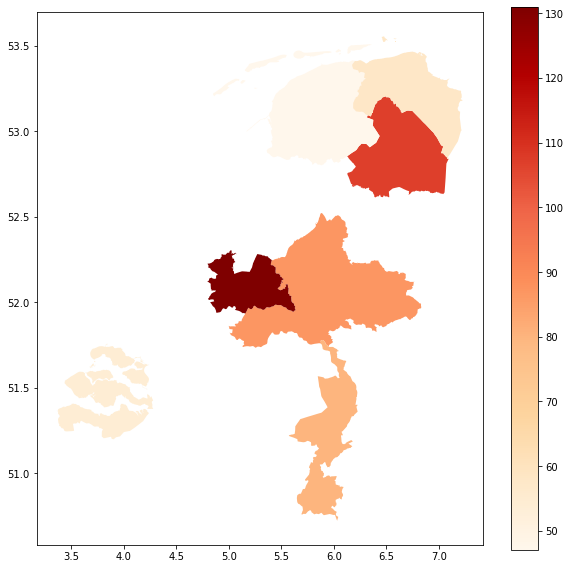

In [344]:
# https://stackoverflow.com/questions/60340577/python-geographical-plot-with-imported-data-e-g-from-the-netherlands

def creat_map_plot(bird = "Greater Canada Goose", year = 2013):
    netherlands_map = gpd.read_file("https://stacks.stanford.edu/file/druid:st293bj4601/data.zip")
    netherlands_map = netherlands_map[netherlands_map["TYPE_1"] == "Provincie"]
    netherlands_map.sort_values("NAME_1", inplace=True)
    netherlands_map = netherlands_map.reset_index(drop=True)
    
    map_df = df_dict[bird].loc[df_dict[bird]["Date"] == year]
    map_df.sort_values("Region", inplace = True)
    map_df.rename(columns = {"Region":"NAME_1"}, inplace = True)
    
    netherlands_map = gpd.GeoDataFrame(netherlands_map.merge(map_df, on = "NAME_1", how = "left"))


    plot = netherlands_map.plot(column="Value", figsize=(10,10), legend=True, cmap='OrRd')
    return plot



pn.extension()

year_slider = pn.widgets.FloatSlider(name='Select year', width=200)
bird_widget = pn.widgets.Select(options= bird_list)


pn.Column('# Select parameters',year_slider ,bird_widget, background='WhiteSmoke')

pn.interact(creat_map_plot, bird = bird_list, year = [year for year in range(2000, 2021)])

In [312]:
def image(bird):
    with open("config.yaml", "r") as config_reader:
        files = yaml.safe_load(config_reader)
        
    return pn.pane.PNG(files[bird], width=500)

### Combining plots

Traceback (most recent call last):
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\io\model.py", line 70, in hold
 yield
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\reactive.py", line 337, in _schedule_change
 self._change_event(doc)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\reactive.py", line 331, in _change_event
 self._process_events(events)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\reactive.py", line 276, in _process_events
 self.param.update(**self_events)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 1877, in update
 self_._batch_call_watchers()
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 2038, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 2000, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\interact.py", line 189, in update_pane
 new_pane, internal = ReplacementPane._update_from_object(
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\pane\base.py", line 383, in _update_from_object
 old_object.object = object
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 351, in _f
 instance_param.__set__(obj, val)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 353, in _f
 return f(self, obj, val)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 1228, in __set__
 obj.param._call_watcher(watcher, event)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 2018, in _call_watcher
 self_._execute_watcher(watcher, (event,))
 File "C:\Users\Hannah\anaconda3\lib\site-packages\param\parameterized.py", line 2000, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\pane\base.py", line 200, in _update_pane
 push(doc, comm)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\io\notebook.py", line 58, in push
 msg = diff(doc, binary=binary)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\io\model.py", line 33, in diff
 msg = Protocol().create("PATCH-DOC", events, use_buffers=binary)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\protocol\__init__.py", line 137, in create
 return self._messages[msgtype].create(*args, **kwargs) # type: ignore [attr-defined]
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 101, in create
 patch_json, buffers = process_document_events(events, use_buffers)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 144, in process_document_events
 return serialize_json(json), buffers or []
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\core\json_encoder.py", line 171, in serialize_json
 return json.dumps(obj, cls=BokehJSONEncoder, allow_nan=False, indent=indent, separators=separators, sort_keys=True, **kwargs)
 File "C:\Users\Hannah\anaconda3\lib\json\__init__.py", line 234, in dumps
 return cls(
 File "C:\Users\Hannah\anaconda3\lib\json\encoder.py", line 199, in encode
 chunks = self.iterencode(o, _one_shot=True)
 File "C:\Users\Hannah\anaconda3\lib\json\encoder.py", line 257, in iterencode
 return _iterencode(o, 0)
ValueError: Out of range float values are not JSON compliant

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
 File "C:\Users\Hannah\anaconda3\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\Hannah\anaconda3\lib\site-packages\panel\viewable.py", line 274, in _on_msg
 doc.unhold()
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\document\document.py", line 799, in unhold
 self.callbacks.unhold()
 File "C:\Users\Hannah\anaconda3\lib\site-packages\bokeh\document\callbacks.py", line 396, in unhold
 self.trigger_on_ch

Tabs
    [0] Column
        [0] Column
            [0] Select(name='bird', options=['Greater Canada Goose', ...], value='Greater Canada Goose')
            [1] Select(name='region', options=['Drenthe', 'Friesland', ...], value='Groningen')
            [2] Select(name='agriculture', options=['Number of Farms Total', ...], value='Number of Farms Total')
        [1] Row
            [0] Bokeh(Figure, name='interactive01850')
    [1] Column
        [0] Column
            [0] Select(name='bird', options=['Greater Canada Goose', ...], value='Greater Canada Goose')
            [1] DiscreteSlider(formatter='%d', name='year', options=[2000, 2001, 2002, ...], value=2013)
        [1] Row
            [0] Str(AxesSubplot, name='interactive01859')
    [2] Column
        [0] Column
            [0] Select(name='bird', options=['Greater Canada Goose', ...], value='Greater Canada Goose')
        [1] Row
            [0] PNG(str, width=500)
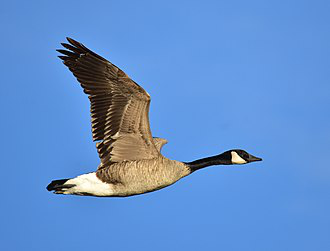

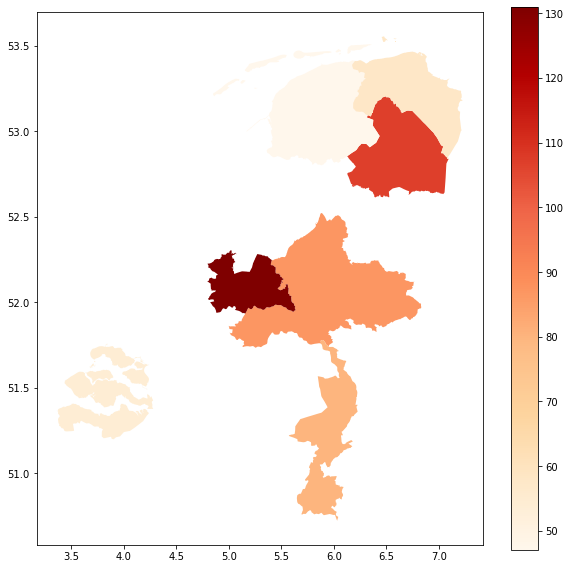

In [345]:
# Lineplot
pn.extension()

# The widgets
bird_widget = pn.widgets.Select(options= bird_list)
region_widget = pn.widgets.Select(options= region_list)
agriculture_widget = pn.widgets.Select(options= agriculture_list)
year_slider = pn.widgets.FloatSlider(name='Select year', width=200)


pn.Column('# Select parameters',region_widget ,bird_widget, agriculture_widget, year_slider, background='WhiteSmoke')

# pn.Column('# Select parameters',year_slider ,bird_widget, background='WhiteSmoke')

p1 = pn.interact(make_plot, bird = bird_list, region = region_list, agriculture = agriculture_list)
p2 = pn.interact(creat_map_plot, bird = bird_list, year = [year for year in range(2000, 2021)])
p3 = pn.interact(image, bird = bird_list)

tabs = pn.Tabs(('Lineplot', p1), ("Geoplot", p2), ("Bird picture", p3))

tabs

### Data quantity

In [314]:
print("There is data available:\n" +
      f"   {len(bird_list)} bird species\n" +
      f"   {len(agriculture_list)} types of agriculture\n" +
      "   12 regions of the Netherlands\n" +
      "   From 2000-2020 from both datasets (21 years total)\n" +
      f"   {len(bird_list) * 12 * 21 * len(agriculture_list)} data points in total"
     )

print("\nPer bird species data available:\n" +
      f"   {len(agriculture_list)*12*21} data points in total\n" +
      f"   {12 * 21} data points per agriculture\n" +
      f"   {21 * len(agriculture_list)} data points per region\n" +
      f"   {len(agriculture_list)*12} data points per year\n" +
      f"   21 data points per region and agriculture"
     )

There is data available:
   29 bird species
   149 types of agriculture
   12 regions of the Netherlands
   From 2000-2020 from both datasets (21 years total)
   1088892 data points in total

Per bird species data available:
   37548 data points in total
   252 data points per agriculture
   3129 data points per region
   1788 data points per year
   21 data points per region and agriculture


### Data quality

In [316]:
total_data = len(bird_list) * 12 * 21 * len(agriculture_list)
missing_bird_data = bird_df.isna().sum().sum()
missing_agriculture_data = agriculture_df.isna().sum().sum()

missing_data_total = 0
for df in df_dict:
    missing_data_total =+ df_dict[df].isna().sum().sum()


print("The amount of missing data:\n" +
      f"   {missing_bird_data} missing bird points ({missing_bird_data/(len(bird_list) * 12 * 21)*100}%)\n" +
      f"   {missing_agriculture_data} missing agriculture data points ({missing_agriculture_data/(total_data/len(bird_list))*100}%)\n" +
      f"   {missing_data_total} missing data in total ({missing_data_total / total_data * 100}%)\n"
     )


The amount of missing data:
   71 missing bird points (0.9715380405035577%)
   1992 missing agriculture data points (5.30520933205497%)
   2685 missing data in total (0.2465809281361237%)

